In [1]:
!python --version

Python 3.6.9


Download data from tsinghua cloud


In [ ]:
# Download training_data
!wget -O training_data.zip https://cloud.tsinghua.edu.cn/f/7eece510dc784e70a083/?dl=1

# Unzip
!unzip training_data.zip -d ./

# Remove unecessary documents
%rm -r training_data/__MACOSX/
%rm training_data.zip

# Check final result
!ls training_data/

Load data from Drive


In [2]:
from google.colab import drive
drive.mount('/content/gdrive')
!unzip "/content/gdrive/My Drive/training_data.zip" -d "./"

# Remove unecessary documents
%rm -r __MACOSX/

Mounted at /content/gdrive
Archive:  /content/gdrive/My Drive/training_data.zip
   creating: ./training_data/
  inflating: ./training_data/.DS_Store  
   creating: ./__MACOSX/
   creating: ./__MACOSX/training_data/
  inflating: ./__MACOSX/training_data/._.DS_Store  
  inflating: ./training_data/cmdb.xlsx  
  inflating: ./__MACOSX/training_data/._cmdb.xlsx  
   creating: ./training_data/2020_05_04/
  inflating: ./training_data/2020_05_04/esb.csv  
  inflating: ./training_data/2020_05_04/.DS_Store  
   creating: ./__MACOSX/training_data/2020_05_04/
  inflating: ./__MACOSX/training_data/2020_05_04/._.DS_Store  
   creating: ./training_data/2020_05_04/trace/
  inflating: ./training_data/2020_05_04/trace/trace_jdbc.csv  
   creating: ./__MACOSX/training_data/2020_05_04/trace/
  inflating: ./__MACOSX/training_data/2020_05_04/trace/._trace_jdbc.csv  
  inflating: ./training_data/2020_05_04/trace/trace_csf.csv  
  inflating: ./__MACOSX/training_data/2020_05_04/trace/._trace_csf.csv  
  inflati

# Import section

In [3]:
# IMPORT SECTION
import numpy as np
import pandas as pd
# import dask.dataframe     # requires python -m pip install 'fsspec>=0.3.3'

import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import ListedColormap

# Time series decomposition
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.api as sm

import datetime

sns.set_context("notebook")
training_data_path = './training_data'

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Acquire data


## esb (business indicator)


In [4]:
# ACQUIRE DATA
# esb (business indicator)
print("{:=^30}".format('  ESB  '))
filename = training_data_path + "/2020_05_04/esb.csv"
print("opening {}".format(filename))
esb_df = pd.read_csv(filename, header=0)
# esb_df = pd.read_csv(filename, header=0, parse_dates=['startTime'], index_col='startTime')

esb_df.rename(columns={
    'serviceName': 'service_name', 
    'startTime': 'start_time'}, 
    inplace = True)

esb_df['start_time'] = pd.to_datetime(esb_df['start_time'], unit='ms')
esb_df['time'] = (esb_df['start_time'] - esb_df['start_time'].min()) / datetime.timedelta(seconds=1) # should be 0 to 24h in seconds

print(esb_df.info())
esb_df.describe()

===========  ESB  ============
opening ./training_data/2020_05_04/esb.csv
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1439 entries, 0 to 1438
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   service_name  1439 non-null   object        
 1   start_time    1439 non-null   datetime64[ns]
 2   avg_time      1439 non-null   float64       
 3   num           1439 non-null   int64         
 4   succee_num    1439 non-null   int64         
 5   succee_rate   1439 non-null   float64       
 6   time          1439 non-null   float64       
dtypes: datetime64[ns](1), float64(3), int64(2), object(1)
memory usage: 78.8+ KB
None


,avg_time,num,succee_num,succee_rate,time
count,1439.000000,1439.000000,1439.000000,1439.0,1439.000000
mean,0.606253,507.325226,507.325226,1.0,43147.213343
std,0.042155,72.569547,72.569547,0.0,24943.870742
min,0.490900,303.000000,303.000000,1.0,0.000000
25%,0.580900,449.000000,449.000000,1.0,21570.000000
50%,0.604100,510.000000,510.000000,1.0,43140.000000
75%,0.631300,565.000000,565.000000,1.0,64710.000000
max,0.923700,704.000000,704.000000,1.0,86340.000000


## host KPI


In [5]:
# ACQUIRE DATA
# host KPI
print("{} host {}".format('='*5, '='*5))
host_df_lst = []
for s_name in ["db_oracle_11g", "dcos_container", "dcos_docker", "mw_redis", "os_linux"]:
    filename = training_data_path + "/2020_05_04/host/" + s_name + ".csv"
    print("opening {}".format(filename))
    temp_df = pd.read_csv(filename, header=0)
    temp_df.rename(columns={'itemid': 'item_id'}, inplace=True) # rename columns so that is follows convention some_special_name
    host_df_lst.append(temp_df)

host_df = pd.concat(host_df_lst) 
print(host_df.info())
host_df.describe()

# NOTE: different itemid describes different KPIs (key performance index)

===== host =====
opening ./training_data/2020_05_04/host/db_oracle_11g.csv
opening ./training_data/2020_05_04/host/dcos_container.csv
opening ./training_data/2020_05_04/host/dcos_docker.csv
opening ./training_data/2020_05_04/host/mw_redis.csv
opening ./training_data/2020_05_04/host/os_linux.csv
<class 'pandas.core.frame.DataFrame'>
Int64Index: 2387373 entries, 0 to 1214607
Data columns (total 6 columns):
 #   Column     Dtype  
---  ------     -----  
 0   item_id    int64  
 1   name       object 
 2   bomc_id    object 
 3   timestamp  int64  
 4   value      float64
 5   cmdb_id    object 
dtypes: float64(1), int64(2), object(3)
memory usage: 127.5+ MB
None


,item_id,timestamp,value
count,2.387373e+06,2.387373e+06,2.387373e+06
mean,7.874626e+14,1.588565e+12,7.031046e+07
std,4.091030e+14,2.493578e+07,6.485663e+08
min,4.871784e+07,1.588522e+12,0.000000e+00
25%,1.000000e+15,1.588543e+12,0.000000e+00
50%,1.000000e+15,1.588565e+12,6.000000e-01
75%,1.000000e+15,1.588586e+12,2.782297e+01
max,1.000000e+15,1.588608e+12,9.433807e+09


## trace

In [ ]:
# ACQUIRE DATA
# trace
print("{:=^30}".format('   trace   '))
trace_df_lst = []
for c_type in ["csf", "fly_remote", "jdbc", "local", "osb", "remote_process"]:
    filename = training_data_path + "/2020_05_04/trace/trace_" + c_type + ".csv"
    print("opening {}".format(filename))
    chunks = pd.read_csv(filename, header=0, chunksize=100000)
    temp_df = pd.concat(chunks)
    temp_df = reduce_mem_usage(temp_df)
    temp_df.rename(
        columns={
          'callType': 'call_type', 
          'startTime': 'start_time', 
          'elapsedTime': 'elapsed_time', 
          'traceId':'trace_id', 
          'serviceName': 'service_name', 
          'dsName': 'ds_name'}, 
        inplace = True) # rename columns so that is follows convention some_special_name except for Id
    trace_df_lst.append(temp_df)
    del temp_df, chunks

# trace_df = pd.concat(trace_df_lst)
# print(trace_df.info())

# NOTE: warning, trace_df is 3.2+ GB large !

# Reduce memory usage


## def reduce_mem_usage

In [ ]:
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                c_prec = df[col].apply(lambda x: np.finfo(x).precision).max()
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max and c_prec == np.finfo(np.float16).precision:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max and c_prec == np.finfo(np.float32).precision:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [ ]:
esb_df = reduce_mem_usage(esb_df)
# host_df = reduce_mem_usage(host_df)
# trace_df = reduce_mem_usage(trace_df)

Mem. usage decreased to  0.05 Mb (25.0% reduction)


# Simple single series analysis
https://www.kaggle.com/caesarlupum/ashrae-start-here-a-gentle-introduction/comments#8.-Simple-Single-Series-Analysis

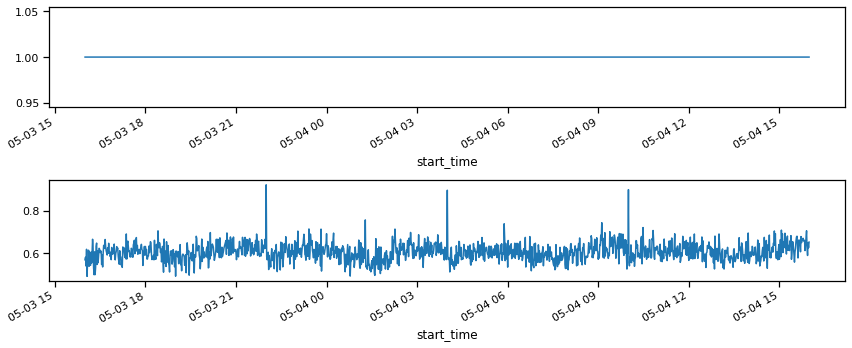

In [ ]:
f, ax = plt.subplots(nrows=2, ncols=1, figsize=(12, 5), tight_layout=True)
succee_rate_ts = esb_df.groupby(['start_time'])['succee_rate'].sum()
avg_time_ts = esb_df.groupby(['start_time'])['avg_time'].sum()

succee_rate_ts.plot(ax=ax[0])
avg_time_ts.plot(ax=ax[1])

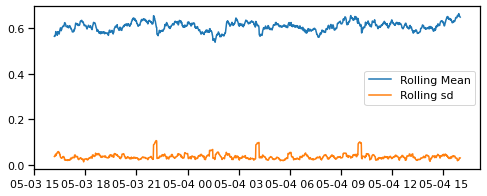

In [ ]:
plt.figure(figsize=(8,3))
win = 12
plt.plot(avg_time_ts.rolling(window=win,center=False).mean(),label='Rolling Mean');
plt.plot(avg_time_ts.rolling(window=win,center=False).std(),label='Rolling sd');
plt.legend()

Text(0.5, 0.98, 'Multiplicative model')

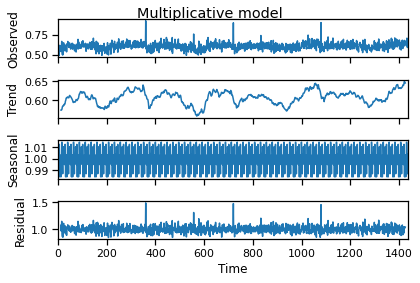

In [ ]:
freq = 24 # which periodicity take ? i guess the input is NOT periodic, so none of the following methods should produce decent results...
mult = sm.tsa.seasonal_decompose(avg_time_ts.values, freq=freq,model="multiplicative") # multiplicative model
fm = mult.plot()
fm.suptitle("Multiplicative model")

In [ ]:
addi = sm.tsa.seasonal_decompose(avg_time_ts.values,freq=freq,model="additive") # additive model
fa = addi.plot()
fa.suptitle("Additive model")

NameError: ignored

# Anomaly Detection using statistical methods
https://medium.com/@jetnew/anomaly-detection-of-time-series-data-e0cb6b382e33

## Exponential smoothing

23.983333333333334


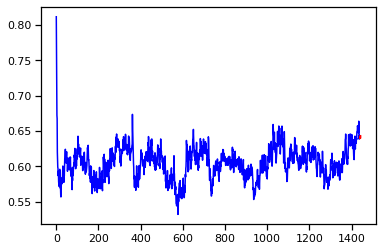

In [ ]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing
periodicity = (esb_df['start_time'].max() - esb_df['start_time'].min()) / datetime.timedelta(hours=1)
print(periodicity)

X = esb_df['avg_time']

fit = ExponentialSmoothing(X, seasonal_periods=3, trend='add', seasonal='add').fit(use_boxcox=True)
fit.fittedvalues.plot(color='blue')
fit.forecast(5).plot(color='red')
plt.show()

## ARIMA

0 / 288
1 / 288


/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2 / 288


/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


3 / 288
4 / 288
5 / 288
6 / 288
7 / 288
8 / 288
9 / 288
10 / 288
11 / 288
12 / 288
13 / 288
14 / 288
15 / 288
16 / 288
17 / 288
18 / 288
19 / 288
20 / 288
21 / 288
22 / 288
23 / 288
24 / 288
25 / 288
26 / 288
27 / 288
28 / 288
29 / 288
30 / 288
31 / 288
32 / 288
33 / 288
34 / 288
35 / 288
36 / 288
37 / 288
38 / 288
39 / 288
40 / 288
41 / 288
42 / 288
43 / 288
44 / 288
45 / 288
46 / 288
47 / 288
48 / 288
49 / 288
50 / 288
51 / 288
52 / 288
53 / 288
54 / 288
55 / 288
56 / 288
57 / 288
58 / 288
59 / 288
60 / 288
61 / 288
62 / 288
63 / 288
64 / 288
65 / 288
66 / 288
67 / 288
68 / 288
69 / 288
70 / 288
71 / 288
72 / 288
73 / 288
74 / 288
75 / 288
76 / 288
77 / 288
78 / 288
79 / 288
80 / 288
81 / 288
82 / 288
83 / 288
84 / 288
85 / 288
86 / 288
87 / 288
88 / 288
89 / 288
90 / 288
91 / 288
92 / 288
93 / 288
94 / 288
95 / 288
96 / 288
97 / 288
98 / 288
99 / 288
100 / 288
101 / 288
102 / 288
103 / 288
104 / 288
105 / 288
106 / 288
107 / 288
108 / 288
109 / 288
110 / 288
111 / 288
112 / 288
113 

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


125 / 288
126 / 288
127 / 288
128 / 288
129 / 288
130 / 288
131 / 288
132 / 288
133 / 288
134 / 288
135 / 288
136 / 288
137 / 288
138 / 288
139 / 288
140 / 288
141 / 288
142 / 288
143 / 288
144 / 288
145 / 288
146 / 288
147 / 288
148 / 288
149 / 288
150 / 288
151 / 288
152 / 288
153 / 288
154 / 288
155 / 288
156 / 288
157 / 288
158 / 288
159 / 288
160 / 288
161 / 288
162 / 288
163 / 288
164 / 288
165 / 288
166 / 288
167 / 288
168 / 288
169 / 288
170 / 288
171 / 288
172 / 288
173 / 288
174 / 288
175 / 288


/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


176 / 288
177 / 288
178 / 288
179 / 288
180 / 288
181 / 288
182 / 288
183 / 288
184 / 288
185 / 288
186 / 288
187 / 288
188 / 288
189 / 288
190 / 288
191 / 288
192 / 288
193 / 288
194 / 288
195 / 288
196 / 288
197 / 288
198 / 288
199 / 288
200 / 288
201 / 288
202 / 288
203 / 288
204 / 288


/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


205 / 288
206 / 288
207 / 288
208 / 288
209 / 288
210 / 288
211 / 288
212 / 288
213 / 288
214 / 288
215 / 288
216 / 288
217 / 288
218 / 288
219 / 288
220 / 288
221 / 288
222 / 288
223 / 288
224 / 288
225 / 288
226 / 288
227 / 288
228 / 288
229 / 288
230 / 288
231 / 288
232 / 288
233 / 288
234 / 288
235 / 288
236 / 288
237 / 288
238 / 288
239 / 288
240 / 288
241 / 288
242 / 288
243 / 288
244 / 288
245 / 288
246 / 288
247 / 288
248 / 288
249 / 288
250 / 288
251 / 288
252 / 288
253 / 288
254 / 288
255 / 288
256 / 288
257 / 288
258 / 288
259 / 288
260 / 288
261 / 288
262 / 288
263 / 288
264 / 288
265 / 288
266 / 288
267 / 288
268 / 288
269 / 288
270 / 288
271 / 288
272 / 288
273 / 288
274 / 288
275 / 288
276 / 288
277 / 288
278 / 288
279 / 288
280 / 288
281 / 288
282 / 288
283 / 288
284 / 288
285 / 288
286 / 288
287 / 288
MSE: 0.002


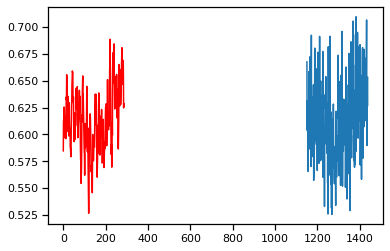

In [ ]:
from statsmodels.tsa.arima_model import ARIMA  # see https://machinelearningmastery.com/arima-for-time-series-forecasting-with-python/
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

p = 10  # lag
d = 2  # difference order
q = 0  # size of moving average window

X = esb_df['avg_time']

train, test = train_test_split(X, test_size=0.20, shuffle=False)
history = train.tolist()
predictions = []

for t in range(len(test)):
    print("\r{} / {}".format(t, len(test)), end='')
    model = ARIMA(history, order=(p,d,q))

    fit = model.fit(disp=False) # disp=verbose
    pred = fit.forecast()[0]
    
    predictions.append(pred)
    history.append(test.iloc[t])
  
print("MSE: {:.3f}".format(mean_squared_error(test, predictions)))

plt.plot(test)
plt.plot(predictions, color='red')
plt.show()

In [ ]:
from google.colab import files
fit.save('arima_model_fit.pkl')
np.savetxt('prediction.csv', predictions)
np.savetxt('history.csv', history)

files.download('arima_model_fit.pkl')
files.download('prediction.csv')
files.download('history.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## HBOS
Histogram-Based Outlier Score (HBOS) is a O(n) linear time unsupervised algorithm that is faster than multivariate approaches at the cost of less precision. It can detect global outliers well but performs poorly on local outlier problems.


contamination is the way to tune this model. It is used to compute the threshold: lower contamination rate means higher threshold (ie. less triggers). The initial 0.1 contamination rate was too high and produced results where the model was almost triggered all the time.

In [ ]:
!pip install kenchi

     |████████████████████████████████| 389kB 13.2MB/s 


360    2020-05-03 22:00:00
557    2020-05-04 01:17:00
720    2020-05-04 04:00:00
833    2020-05-04 05:53:00
1027   2020-05-04 09:07:00
1080   2020-05-04 10:00:00
1109   2020-05-04 10:29:00
Name: start_time, dtype: datetime64[ns]
CPU times: user 43.7 ms, sys: 2.08 ms, total: 45.8 ms
Wall time: 44.4 ms


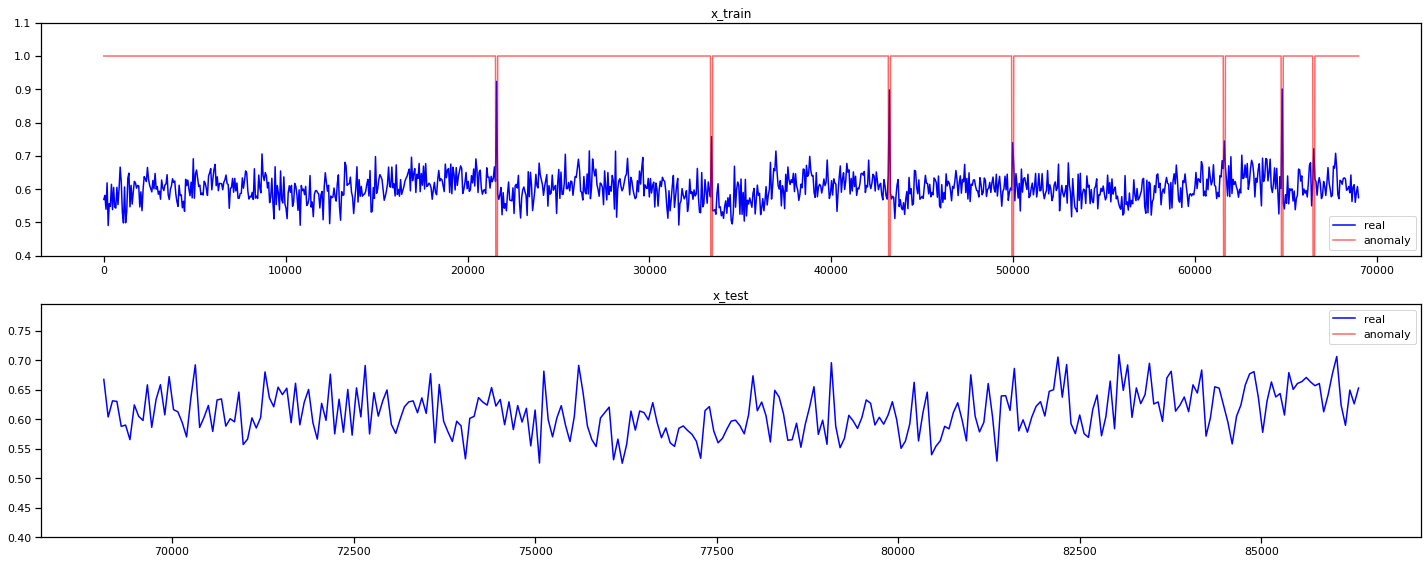

In [ ]:
%%time
from kenchi.outlier_detection.statistical import HBOS
from sklearn.model_selection import train_test_split


X = (esb_df[['time', 'avg_time']])
x_train, x_test = train_test_split(X, test_size=0.20, shuffle=False)


hbos = HBOS(contamination=0.01, novelty=True).fit(x_train)
# contamination (float, default 0.1) – Proportion of outliers in the data set. Used to define the threshold.
# novelty (bool, default False) – If True, you can use predict, decision_function and anomaly_score on new unseen data and not on the training data.
y_pred = hbos.predict(x_train)
f, ax = plt.subplots(nrows=2, ncols=1, figsize=(20,8), tight_layout=True)
ax[0].plot(x_train['time'], x_train['avg_time'], 'b', label='real')
ax[0].plot(x_train['time'], y_pred, 'r', alpha=.6, label='anomaly')
ax[0].set_ylim(0.4)
ax[0].legend()
ax[0].set_title('x_train')

print("Anomalies detected at the following timestamps")
print(esb_df['start_time'].iloc[np.where(y_pred<1)])

y_pred = hbos.predict(x_test)
ax[1].plot(x_test['time'], x_test['avg_time'], 'b', label='real')
ax[1].plot(x_test['time'], y_pred, 'r', alpha=.6, label='anomaly')
ax[1].set_ylim(0.4)
ax[1].legend()
ax[1].set_title('x_test')



https://blog.statsbot.co/time-series-anomaly-detection-algorithms-1cef5519aef2

# Unsupervised learning

## K-means clustering
K-Means Clustering is generally not useful in anomaly detection due to its sensitivity to outliers. Centroids cannot be updated if a set of objects close to it is empty.

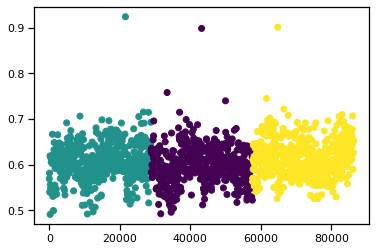

In [ ]:
from sklearn.cluster import KMeans

X = np.array(esb_df[['time', 'avg_time']])

clusters = 3
y_pred = KMeans(n_clusters=clusters).fit_predict(X)

plt.scatter(X[:,0], X[:,1], c=y_pred)
plt.show()

## Hierarchical clustering


In [ ]:
from sklearn.cluster import AgglomerativeClustering
X = esb_df['avg_time']


clusters = 3
y_pred = AgglomerativeClustering(n_clusters=clusters).fit_predict(X)


from scipy.cluster.hierarchy import linkage, fcluster, dendrogram

clusters=5
cls = linkage(X, method='ward')
y_pred = fcluster(cls, t=clusters, criterion='maxclust')

dendrogram(cls)
plt.show()

## LSTM - self supervised


In [ ]:

from keras.layers import LSTM, Dense, RepeatVector, TimeDistributed
from keras.models import Sequential
X = esb_df['avg_time']

class LSTM_Autoencoder:
  def __init__(self, optimizer='adam', loss='mse'):
    self.optimizer = optimizer
    self.loss = loss
    self.n_features = 1
    
  def build_model(self):
    timesteps = self.timesteps
    n_features = self.n_features
    model = Sequential()
    
    # Encoder
    model.add(LSTM(timesteps, activation='relu', input_shape=(timesteps, n_features), return_sequences=True))
    model.add(LSTM(16, activation='relu', return_sequences=True))
    model.add(LSTM(1, activation='relu'))
    model.add(RepeatVector(timesteps))
    
    # Decoder
    model.add(LSTM(timesteps, activation='relu', return_sequences=True))
    model.add(LSTM(16, activation='relu', return_sequences=True))
    model.add(TimeDistributed(Dense(n_features)))
    
    model.compile(optimizer=self.optimizer, loss=self.loss)
    model.summary()
    self.model = model
    
  def fit(self, X, epochs=3, batch_size=32):
    self.timesteps = X.shape[1]
    self.build_model()
    
    input_X = np.expand_dims(X, axis=2)
    self.model.fit(input_X, input_X, epochs=epochs, batch_size=batch_size)
    
  def predict(self, X):
    input_X = np.expand_dims(X, axis=2)
    output_X = self.model.predict(input_X)
    reconstruction = np.squeeze(output_X)
    return np.linalg.norm(X - reconstruction, axis=-1)
  
  def plot(self, scores, timeseries, threshold=0.95):
    sorted_scores = sorted(scores)
    threshold_score = sorted_scores[round(len(scores) * threshold)]
    
    plt.title("Reconstruction Error")
    plt.plot(scores)
    plt.plot([threshold_score]*len(scores), c='r')
    plt.show()
    
    anomalous = np.where(scores > threshold_score)
    normal = np.where(scores <= threshold_score)
    
    plt.title("Anomalies")
    plt.scatter(normal, timeseries[normal][:,-1], s=3)
    plt.scatter(anomalous, timeseries[anomalous][:,-1], s=5, c='r')
    plt.show()
    
lstm_autoencoder = LSTM_Autoencoder(optimizer='adam', loss='mse')
lstm_autoencoder.fit(normal_timeseries, epochs=3, batch_size=32)
scores = lstm_autoencoder.predict(test_timeseries)
lstm_autoencoder.plot(scores, test_timeseries, threshold=0.95)

## PCA

## Invariant miners